# Import Libraries

In [1]:
# Import built-in Python libs
from pathlib import Path
from typing import List

# Import data science libs
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Import deep learning libs
import pytorch_lightning as pl
import torchmetrics
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Import weights & bias
import wandb

# Import data preprocessing libs
from tokenizers import Tokenizer
from torch.utils.data import DataLoader

%matplotlib inline

In [2]:
utils_path = Path.cwd().parent / "utils"
sys.path.append(str(utils_path))
from custom_tokenizer import load_jieba_tokenizer, load_janome_tokenizer

# Job Selection

In [ ]:
job = 0  # 0 - sentencepiece, 1 - language specific

job_name = ["transformer_sentencepiece_ch2jp", "transformer_language_specific_ch2jp"]

tokenizer_job = ["sentencepiece", "language_specific"]
ch_tokenizer_job = ["ch_tokenizer.json", "jieba_tokenizer.json"]
jp_tokenizer_job = ["jp_tokenizer.json", "janome_tokenizer.json"]
embedding_job = ["sentencepiece_embedding", "language_specific_embedding"]

In [ ]:
method = 0
method_name = ["semantic", "phonetic", "meta", "concat"]

ch_embedding_method = [
    "ch_embedding.npy",
    "chp_embedding.npy",
    "ch_meta_embedding.npy",
    "ch_concat_embedding.npy",
]

jp_embedding_method = [
    "jp_embedding.npy",
    "jpp_embedding.npy",
    "jp_meta_embedding.npy",
    "jp_concat_embedding.npy",
]

# Config and WandB

In [2]:
config = {
    "enc_layers": 3,
    "dec_layers": 3,
    "enc_heads": 6,
    "dec_heads": 6,
    "enc_pf_dim": 512,
    "dec_pf_dim": 512,
    "enc_dropout": 0.1,
    "dec_dropout": 0.1,
    "hid_dim": (300 if method != 3 else 600),
    "lr": 7e-4,
    "batch_size": 64,
    "num_workers": 12,
    "precision": 16,
}

In [ ]:
run = wandb.init(
    project="phonetic-translation",
    entity="windsuzu",
    group="experiments",
    job_type=job_name[job] + "-" + method_name[method],
    config=config,
    reinit=True,
)

# Download Datasets, Tokenizers, Embedding, DataModule

## Raw Data

In [4]:
train_data_art = run.use_artifact("sampled_train:latest")
train_data_dir = train_data_art.download()

dev_data_art = run.use_artifact("dev:latest")
dev_data_dir = dev_data_art.download()

test_data_art = run.use_artifact("test:latest")
test_data_dir = test_data_art.download()

data_dir = {
    "train": train_data_dir,
    "dev": dev_data_dir,
    "test": test_data_dir,
}

wandb: Downloading large artifact filtered_train:latest, 99.47MB. 2 files... Done. 0:0:0


## Tokenizer

In [5]:
tokenizer_art = run.use_artifact(f"{tokenizer_job[job]}:latest")
tokenizer_dir = tokenizer_art.download()

src_tokenizer_dir = Path(tokenizer_dir) / ch_tokenizer_job[job]
trg_tokenizer_dir = Path(tokenizer_dir) / jp_tokenizer_job[job]

## Pretrained Embedding

In [ ]:
embedding_art = run.use_artifact(f"{embedding_job[job]}:latest")
embedding_dir = embedding_art.download()

ch_embedding_dir = Path(embedding_dir) / ch_embedding_method[method]
jp_embedding_dir = Path(embedding_dir) / jp_embedding_method[method]

In [ ]:
src_embedding = np.load(Path(ch_embedding_dir))
trg_embedding = np.load(Path(jp_embedding_dir))

src_embedding = torch.FloatTensor(src_embedding)
trg_embedding = torch.FloatTensor(trg_embedding)

In [ ]:
print(src_embedding.shape)
print(trg_embedding.shape)

## DataModule

In [6]:
class SentencePieceDataModule(pl.LightningDataModule):
    def __init__(
        self,
        data_dir,
        src_tokenizer_dir,
        trg_tokenizer_dir,
        batch_size=128,
        num_workers=8,
        pin_memory=True,
        job=0,
    ):
        super().__init__()
        self.data_dir = data_dir
        self.src_tokenizer_dir = src_tokenizer_dir
        self.trg_tokenizer_dir = trg_tokenizer_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.pin_memory = pin_memory
        self.job = job

    def setup(self, stage=None):
        self.src_tokenizer = self._load_tokenizer(self.src_tokenizer_dir)
        self.trg_tokenizer = self._load_tokenizer(self.trg_tokenizer_dir)

        if stage == "fit":
            self.train_set = self._data_preprocess(self.data_dir["train"])
            self.val_set = self._data_preprocess(self.data_dir["dev"])

        if stage == "test":
            self.test_set = self._data_preprocess(self.data_dir["test"])

    def train_dataloader(self):
        return DataLoader(
            self.train_set,
            self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
            collate_fn=self._data_batching_fn,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_set,
            self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
            collate_fn=self._data_batching_fn,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_set,
            self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
            collate_fn=self._data_batching_fn,
        )

    def _read_data_array(self, data_dir):
        with open(data_dir, encoding="utf8") as f:
            arr = f.readlines()
        return arr

    def _load_tokenizer(self, tokenizer_dir):
        if self.job == 0:
            return Tokenizer.from_file(str(tokenizer_dir))
        else:
            return (
                load_jieba_tokenizer(tokenizer_dir)
                if "jieba" in str(tokenizer_dir)
                else load_janome_tokenizer(tokenizer_dir)
            )

    def _data_preprocess(self, data_dir):
        src_txt = self._read_data_array(Path(data_dir) / "ch.txt")
        trg_txt = self._read_data_array(Path(data_dir) / "jp.txt")
        parallel_txt = np.array(list(zip(src_txt, trg_txt)))
        return parallel_txt

    def _data_batching_fn(self, data_batch):
        data_batch = np.array(data_batch)  # shape=(batch_size, 2=src+trg)

        src_batch = data_batch[:, 0]  # shape=(batch_size, )
        trg_batch = data_batch[:, 1]  # shape=(batch_size, )

        # src_batch=(batch_size, longest_sentence)
        # trg_batch=(batch_size, longest_sentence)
        src_batch = self.src_tokenizer.encode_batch(src_batch)
        trg_batch = self.trg_tokenizer.encode_batch(trg_batch)

        # We have to sort the batch by their non-padded lengths in descending order,
        # because the descending order can help in `nn.utils.rnn.pack_padded_sequence()`,
        # which it will help us ignoring the <pad> in training rnn.
        # https://meetonfriday.com/posts/4d6a906a
        src_batch, trg_batch = zip(
            *sorted(
                zip(src_batch, trg_batch),
                key=lambda x: sum(x[0].attention_mask),
                reverse=True,
            )
        )

        return src_batch, trg_batch


In [7]:
dm = SentencePieceDataModule(
    data_dir,
    src_tokenizer_dir,
    trg_tokenizer_dir,
    config["batch_size"],
    config["num_workers"],
    job=job
)

### Test DataModule

In [8]:
dm.setup("test")

In [9]:
input_dim = dm.src_tokenizer.get_vocab_size()
output_dim = dm.trg_tokenizer.get_vocab_size()
print(input_dim, output_dim)

src_pad_idx = dm.src_tokenizer.token_to_id("[PAD]")
print(src_pad_idx)

32000 32000
3


In [10]:
i = 3
for src, trg in dm.test_dataloader():
    print(len(src), src[i], src[i].tokens)
    print()
    print(len(trg), trg[i], trg[i].tokens)
    break

42 Encoding(num_tokens=105, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]) ['[BOS]', '_从', '千叶县', '手', '贺', '川', '北', '岸', '同时', '确认', '毛', '脉', '酸', '模', '和', '竹', '叶', '眼', '子', '菜', '和', '眼', '子', '菜', '中', '_,', '_并', '考虑到', '眼', '子', '菜', '有', '毛', '脉', '酸', '模', '和', '竹', '叶', '眼', '子', '菜', '的', '杂交', '种', '的可能性', '_(', '_角', '野', '_)', '_。', '[EOS]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']

42 Encoding(num_tokens=117, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, over

# Build Lightning Model

## Encoder

![](../assets/transformer-encoder.png)

若輸入有 5 個 token: $X = (x_1, x_2, x_3, x_4, x_5)$，那麼經過整個 `encoder` 就會得到 $Z = (z_1, z_2, z_3, z_4, z_5)$，這 5 個分別都是 `context vectors`，他們不像在 RNN 裡被叫做 `hidden state`，是因為他們已經讀過所有的 token 資訊，而不像在 RNN 裡，時間 `t` 時只讀過 $x_t$ 之前的資訊。

---

首先 token 一樣會經過一般的 `word embedding`，並透過另一個 `positional embedding` 來獲取 token 位置的資訊，這個 positional embedding 的大小等於句子的長度，若今天我們想解決的句子長度為 100，那麼 `positional embedding` 的大小 (`vocab_size`) 就會等於 100。

在 `Attention is all you need` 裡面是使用固定的 embedding，而較新的 transformer 架構都會採用可以被訓練的 `positional embedding`；所以這邊我們使用後者。

`word embedding` 會跟 `positional embedding` 相加，得到文字和位置的資訊。但在相加之前，`word embedding` 會先乘上一個 scaling factor $\sqrt{d_\text{model}}$ (`hid_dim`)，用來降低 `embedding` 的差異性 (variance)。

合成後的 `embedding` 就會經過 $N$ 個 encoder layer 來取得 $Z$ (`context vectors`)，輸出給 decoder 做預測。

---

這邊的 `src_mask` 和在 RNN 的一樣，沒有 `<pad>` 的地方是 1，有 `<pad>` 的地方是 0。

In [141]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, max_len=250):
        super().__init__()
        
        self.tok_embedding = nn.Embedding.from_pretrained(src_embedding)
        self.pos_embedding = nn.Embedding(max_len, hid_dim)
        
        self.layers = nn.ModuleList([
            EncoderLayer(hid_dim, n_heads, pf_dim, dropout) for _ in range(n_layers)
        ])
        
        self.dropout = nn.Dropout(dropout)
        
        self.register_buffer("scale", torch.sqrt(torch.FloatTensor([hid_dim])))

        
    def forward(self, src, src_mask):
        # src      = [batch_size, src_len]
        # src_mask = [batch_size, 1, 1, src_len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).type_as(src)
        # pos = [batch_size, src_len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        # src = [batch_size, src_len, hid_dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
        # src = [batch_size, src_len, hid_dim]
        
        return src

## Encoder Layer

在每個 encoder layer (不共享參數) 當中，分別發生了一些事件，可以細分成四個:

1. 將 `src` 和 `src_mask` 丟入 multi-head attention layer 中，得到的結果 `_src` 做 dropout
2. 和 `_src` 和 `src` 做 residual connection，然後丟到 layer normalization layer 得到新的 `src`
3. 將新的 `src` 丟到 position-wise feedforward layer 得到 `_src` 並且在做一次 dropout
4. `_src` 和 `src` 重複步驟二，做 residual connection 和 layer normalization，得到最終的 `src`

---

因為在 transformer 中的 attention 都是原句 (source sentence) 和自己本身計算出來的，而不是參考別的句子計算而成，所以又稱為 `self-attention`。

---

裡面執行兩次的 layer nomarlization，其目的是要將所有參數一般化為 mean=0 和 std=1，能夠讓擁有大量參數的網路更容易訓練。


In [142]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, src, src_mask):
        # src     = [batch_size, src_len, hid_dim]
        # src_mask = [batch_size, 1, 1, src_len]
        
        # self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        # dropout, residual connection, layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        # src = [batch_size, src_len, hid_dim]
        
        
        # positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        # dropout, residual connection, layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        # src = [batch_size, src_len, hid_dim]
        
        return src

## Attention

<img src="../assets/transformer-attention.png" width=500>

Attention 可以被視為 `query`, `key`, `value`, 其中 query 和 key 作用 (dot-product) 得到 `attention vector`，再拿來和 value 相乘獲得 weighted sum（上圖左）。在 transformer 中會將 dot-product 後的結果先除以 $\sqrt{d_k}$，$d_k$ 是 `head_dim` (`hid_dim // n_heads`)，原因是避免乘積越來越大，讓梯度越來越小。

$$
\text{Attention}(Q, K, V) = \text{Softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

---

Transformer 進一步將 Q, K, V 透過 `hid_dim` 拆成 `h` 個 heads，不但能平行運算 `h` 個 head，還能夠讓每一個 head 學到不同的 attention concepts。最後再將 `h` 個 head 重新組合回 `hid_dim` 的 shape 即可。

$$
\begin{aligned}
\text{head}_i &= \text{Attention}(QW_i^Q, KW_i^K, VW_i^V) \\
\text{MultiHeadAttention}(Q, K, V) &= \text{Concat}(\text{head}_1, \cdots, \text{head}_h)W^O
\end{aligned}
$$

上面的 $W^Q, W^K, W^V$，分別是 `fc_q`, `fc_k`, `fc_v`，是將 Q, K, V 切成 `h` 個 head 前的 linear layer；而 $W^O$ 是最終輸出前的 linear layer `fc_o`。

---

整個 attention 運算過程:

1. 透過 `fc_q`, `fc_k`, `fc_v` 計算 $QW^Q, KW^K, VW^V$ 得到 Q, K, V
2. 將 Q, K, V 透過 `hid_dim` 拆成 `n_heads` 個，每個擁有維度 `head_dim`，並且 `permute` 成正確的順序，使他們可以相乘
3. 計算 `energy` = Q * V / sqrt(`head_dim`), 其中 `head_dim = hid_dim // n_heads`
4. 接著 mask 算好的 `energy`，移除對 `<pad>` 的 attention
5. 對 `energy` 做 softmax 得到 `attention_vector`
6. 對 `attention_vector` 做 dropout 後和 V 相乘獲得 `weighted_sum`
7. 將 `n_heads` 個 `weighted_sum` 合併回一個
8. 與 $W^O$ (fc_o) 相乘

In [143]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.register_buffer("scale", torch.sqrt(torch.FloatTensor([hid_dim])))

        
    def forward(self, query, key, value, mask=None):

        # query = [batch_size, query_len, hid_dim]
        # key = [batch_size, key_len, hid_dim]
        # value = [batch_size, value_len, hid_dim]
        
        batch_size = query.shape[0]
        
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        # Q = [batch_size, query_len, hid_dim]
        # K = [batch_size, key_len, hid_dim]
        # V = [batch_size, value_len, hid_dim]
        
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        # Q = [batch_size, n_heads, query_len, head_dim]
        # K = [batch_size, n_heads, key_len, head_dim]
        # V = [batch_size, n_heads, value_len, head_dim]
        

        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        # energy = [batch_size, n_heads, query_len, key_len]
        
        attention = torch.softmax(energy, dim = -1)
        # attention = [batch_size, n_heads, query_len, key_len]
        
        x = torch.matmul(self.dropout(attention), V)
        # x = [batch_size, n_heads, query_len, head_dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        # x = [batch_size, query_len, n_heads, head_dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        # x = [batch_size, query_len, hid_dim]
        
        x = self.fc_o(x)
        # x = [batch_size, query_len, hid_dim]
        
        return x, attention

## Position-wise Feedforward Layer

In [144]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # x = [batch_size, seq_len, hid_dim]
        
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        # x = [batch_size, seq_len, pf_dim]
        
        
        x = self.fc_2(x)
        # x = [batch_size, seq_len, hid_dim]
        
        return x

## Decoder

![](../assets/transformer-decoder.png)

Decoder 將使用 source context vector (representation) $Z$，來預測下一個 token $\hat{y}$。然後從答案 $y$ 計算 loss，用來更新所有網路參數權重。

---

Decoder 和 encoder 十分相似，只有些許地方不同。首先，多了一個 `masked multi-head attention layer`，在這個 layer 裡面，目標句子 (trg sentence) 會和自己做 `self-attention`，並且會加入更特別的 mask，防止 decoder 預先看到未來要預測的單字。

第二，在第二層的 `multi-head attention layer` 是由 decoder context vector (representation) 當作 `query`，而 encoder context vector (representation) 當作 `key` 和 `value`。

---

Encoder 和 Decoder 裡面的層數不用一致。


In [145]:
class Decoder(nn.Module):
    def __init__(
        self, output_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, max_len=100
    ):
        super().__init__()

        self.tok_embedding = nn.Embedding.from_pretrained(trg_embedding)
        self.pos_embedding = nn.Embedding(max_len, hid_dim)

        self.layers = nn.ModuleList(
            [DecoderLayer(hid_dim, n_heads, pf_dim, dropout) for _ in range(n_layers)]
        )

        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
        self.register_buffer("scale", torch.sqrt(torch.FloatTensor([hid_dim])))
        
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        # trg = [batch_size, trg_len]
        # enc_src = [batch_size, src_len, hid_dim]
        # trg_mask = [batch_size, 1, trg_len, trg_len]
        # src_mask = [batch_size, 1, 1, src_len]
        
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).type_as(trg)
        # pos = [batch_size, trg_len]
        
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        # trg = [batch_size, trg_len, hid_dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        # trg = [batch_size, trg_len, hid_dim]
        # attention = [batch_size, n heads, trg_len, src_len]
        
        output = self.fc_out(trg)
        # output = [batch_size, trg_len, output_dim]
        
        return output, attention

## Decoder Layer

Decoder layer 的第一層 trg 和自己的 `self-attention`，也就是自己作為 Q, K, V 來計算 attention，裡面使用 `trg_mask` 來防止計算 attention 在 `<pad>` 或之後的答案上。

---

Decoder layer 的第二層是 trg 和 encoder context vector (representation) 的 `multi-head attention`，使用 trg 作為 `query`，而 encoded src 作為 `key` 和 `value`，這邊使用 `src_mask` 防止計算 attention 在 src 裡的 `<pad>` 上。

---

Decoder layer 的第三層是一個 position-wise feedforward layer，沒什麼特別的。

---

整個 decoder layer 的流程是:

1. trg -> `self-attention` -> _trg -> `dropout` -> _trg
2. `residual`(trg + _trg) -> `layer-norm` -> trg
3. trg + src -> `multi-head attention` -> _trg -> `dropout` -> _trg
4. `residual`(trg + _trg) -> `layer-norm` -> trg
5. trg -> `positionwise-feedforward` -> _trg -> `dropout` -> _trg
6. `residual`(trg + _trg) -> `layer-norm` -> trg

In [146]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    
    def forward(self, trg, enc_src, trg_mask, src_mask):
        # trg = [batch_size, trg_len, hid_dim]
        # enc_src = [batch_size, src_len, hid_dim]
        # trg_mask = [batch_size, 1, trg_len, trg_len]
        # src_mask = [batch_size, 1, 1, src_len]
        
        # self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        # dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
         
        # trg = [batch_size, trg_len, hid_dim]
        # ====================================
        
        # encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        # dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        
        # trg = [batch_size, trg_len, hid_dim]
        # ====================================
        
        
        # positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        # dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        # trg = [batch_size, trg_len, hid_dim]
        # ====================================
        
        # attention = [batch_size, n_heads, trg_len, src_len]
        
        return trg, attention

## Full Seq2Seq Model

In [174]:
class Seq2SeqModel(pl.LightningModule):
    def __init__(self, input_dim, output_dim, trg_tokenizer, config):
        super().__init__()
        self.trg_pad_idx = trg_tokenizer.token_to_id("[PAD]")
        self.trg_tokenizer = trg_tokenizer
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.encoder = Encoder(
            input_dim,
            config["hid_dim"],
            config["enc_layers"],
            config["enc_heads"],
            config["enc_pf_dim"],
            config["enc_dropout"],
        )

        self.decoder = Decoder(
            output_dim,
            config["hid_dim"],
            config["dec_layers"],
            config["dec_heads"],
            config["dec_pf_dim"],
            config["dec_dropout"],
        )

        self.lr = config["lr"]
        self.apply(self.initialize_weights)
    
    
    def initialize_weights(self, m):
        if hasattr(m, 'weight') and m.weight.dim() > 1:
            nn.init.xavier_uniform_(m.weight.data)
    
    
    # Training
    # Use only when training and validation
    def _forward(self, src, trg):
        # src = list of Encoding([ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
        # trg = list of Encoding([ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

        # src_batch = [batch_size, src_len]
        # src_mask  = [batch_size, 1, 1, src_len]
        src_batch = torch.tensor([e.ids for e in src], device=self.device)
        src_mask = torch.tensor([e.attention_mask for e in src], device=self.device).unsqueeze(1).unsqueeze(2)
        
        # trg_batch = [batch_size, trg_len-1]
        # trg_mask  = [batch_size, 1, trg_len-1, trg_len-1]
        trg_batch = torch.tensor([e.ids[:-1] for e in trg], device=self.device)
        trg_pad_mask = torch.tensor([e.attention_mask[:-1] for e in trg], device=self.device).unsqueeze(1).unsqueeze(2)
        
        trg_len = trg_batch.shape[1]
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        trg_mask = trg_pad_mask & trg_sub_mask
        
        # enc_src = [batch_size, src_len, hid_dim]
        enc_src = self.encoder(src_batch, src_mask)
        
        # output = [batch_size, trg_len, output_dim]
        # attention = [batch_size, n_heads, trg_len, src_len]
        output, attention = self.decoder(trg_batch, enc_src, trg_mask, src_mask)
        
        return output, attention


    def training_step(self, batch, batch_idx):
        # both are lists of encodings
        src, trg = batch
        
        y = torch.tensor([e.ids for e in trg], device=self.device)
        preds, _ = self._forward(src, trg)
        # y    = [batch_size, trg_len]
        # pred = [batch_size, trg_len-1, output_dim]
        
        output_dim = preds.shape[-1]
        
        # y    = [batch_size * (trg_len-1)]
        # pred = [batch_size * (trg_len-1), output_dim]
        y = y[:, 1:].contiguous().view(-1)
        preds = preds.contiguous().view(-1, output_dim)
        
        loss = F.cross_entropy(preds, y, ignore_index=self.trg_pad_idx)
        self.log("train_loss", loss)

        perplexity = torch.exp(loss)
        self.log("train_ppl", perplexity)
        
        if self.global_step % 100 == 0:
            torch.cuda.empty_cache()
            
        return loss
    
    
    def validation_step(self, batch, batch_idx):
        src, trg = batch
        y = torch.tensor([e.ids for e in trg], device=self.device)
        preds, _ = self._forward(src, trg)
        
        output_dim = preds.shape[-1]
        y = y[:, 1:].contiguous().view(-1)
        preds = preds.contiguous().view(-1, output_dim)
        
        loss = F.cross_entropy(preds, y, ignore_index=self.trg_pad_idx)
        self.log("valid_loss", loss, sync_dist=True)
        
        perplexity = torch.exp(loss)
        self.log("valid_ppl", perplexity, sync_dist=True)
        
    
    # Inference
    # * Let you use the pl model as a pytorch model.
    # * 
    # * pl_model.eval()
    # * pl_model(X)
    # *
    def forward(self, src, max_len=100):
        # src_batch    = [batch_size, src_len]
        # src_mask     = [batch_size, 1, 1, src_len]
        # real_src_len = [batch_size] (src_len without <pad>)
        src_batch = torch.tensor([e.ids for e in src], device=self.device)
        src_mask = torch.tensor([e.attention_mask for e in src], device=self.device).unsqueeze(1).unsqueeze(2)
        batch_size = src_batch.shape[0]
        
        # first input to the decoder = [BOS] tokens
        # trg_batch = [batch_size, 1]
        trg_batch = torch.tensor([self.trg_tokenizer.token_to_id("[BOS]")], device=self.device).repeat(batch_size).unsqueeze(1)
        
        # enc_src = [batch_size, src_len, hid_dim]
        enc_src = self.encoder(src_batch, src_mask)
        
        for _ in range(1, max_len):
            trg_pad_mask = (trg_batch != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
            trg_sub_mask = torch.tril(torch.ones((trg_batch.shape[1], trg_batch.shape[1]), device = self.device)).bool()
            trg_mask = trg_pad_mask & trg_sub_mask
            # trg_mask = [batch_size, 1, trg_len, trg_len]
            
            # output = [batch_size, trg_len, output_dim]
            # attention = [batch_size, n_heads, trg_len, src_len]
            output, attention = self.decoder(trg_batch, enc_src, trg_mask, src_mask)
            pred = output.argmax(2)[:, -1].unsqueeze(1)
            
            trg_batch = torch.cat([trg_batch, pred], dim=1)
        
        real_src_len = torch.sum(src_mask, axis=3).view(-1)

        return trg_batch, attention, real_src_len
        
        
    def test_step(self, batch, batch_idx):
        src, trg = batch
        preds, attn_matrix, real_src_len = self(src)
        
        # attn_matrix  = [batch_size, n_heads, trg_len, src_len]
        # preds        = [batch_size, trg_len]
        # real_src_len = [batch_size]
        
        # convert `preds` tensor to list of real sentences (tokens)
        # meaning to cut the sentence by [EOS] and remove the [PAD] tokens
        
        # eos_pos = dict(sentence_idx: first_pad_position)
        #
        # e.g., {0: 32, 2: 55} 
        # Meaning that we have 32 tokens (include [EOS]) in the first predicted sentence
        # and `max_len` tokens (no [EOS]) in the second predicted setence
        # and 55 tokens (include [EOS]) in the third predicted sentence
        eos_pos = dict(reversed((preds == self.trg_tokenizer.token_to_id("[EOS]")).nonzero().tolist()))
    
        pred_sentences, attn_matrices = [], []
        for idx, (sentence, attention, src_len) in enumerate(zip(preds, attn_matrix, real_src_len)):
            
            # sentence  = [trg_len_with_pad]
            #           = [real_trg_len]
            pred_sentences.append(sentence[:eos_pos.get(idx)+1 if eos_pos.get(idx) else None])
            
            # attention = [n_heads, trg_len_with_pad, src_len_with_pad]
            #           = [n_heads, real_trg_len, real_src_len]
            attn_matrices.append(attention[:, :eos_pos.get(idx)+1 if eos_pos.get(idx) else None, :src_len])
        
        # source sentences for displaying attention matrix 
        src = [[token for token in e.tokens if token != "[PAD]"] for e in src]
        
        # target sentences for calculating BLEU scores
        trg = [[token for token in e.tokens if token != "[PAD]"] for e in trg]
        
        return pred_sentences, attn_matrices, src, trg
        
    
    def test_epoch_end(self, test_outputs):
        outputs = []
        for (pred_sent_list, attn_list, src_list, trg_list) in test_outputs:
            for pred_sent, attn, src, trg in list(zip(pred_sent_list, attn_list, src_list, trg_list)):
                pred_sent = list(map(self.trg_tokenizer.id_to_token, pred_sent))
                outputs.append((pred_sent, attn, src, trg))
        
        # outputs = list of predictions of testsets, each has a tuple of (pred_sentence, attn_matrix, src_sentence, trg_sentence)
        # pred_sentence = [trg_len]
        # attn_matrix   = [n_heads, trg_len, src_len]
        # src_sentence  = [src_len]
        # trg_sentence  = [trg_len]
        self.test_outputs = outputs
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    
    
    def optimizer_zero_grad(self, epoch, batch_idx, optimizer, optimizer_idx):
        optimizer.zero_grad(set_to_none=True)
        

In [175]:
wandb_logger = pl.loggers.WandbLogger()

model = Seq2SeqModel(
    input_dim,
    output_dim,
    dm.trg_tokenizer,
    config,
)

In [176]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 34,044,872 trainable parameters


# Training

In [ ]:
ckpt_dir = Path("checkpoints")

checkpoint = pl.callbacks.ModelCheckpoint(dirpath=ckpt_dir,  # path for saving checkpoints
                                          filename=f"{job_name[job]}-{method_name[method]}-" + "{epoch}-{valid_loss:.3f}",
                                          monitor="valid_loss",
                                          mode="min",
                                          save_top_k=3,
                                         )

In [ ]:
trainer = pl.Trainer(
    fast_dev_run=True,
    logger=wandb_logger,
    gpus=1,
    max_epochs=5,
    gradient_clip_val=1,
    precision=config["precision"],
    callbacks=[checkpoint],
#     resume_from_checkpoint=ckpt_dir / "jp2ch-valid_loss=4.153-bleu=0.3916.ckpt",
)

In [179]:
trainer.fit(model, datamodule=dm)

# Testing (BLEU Scores)

In [180]:
# model = Seq2SeqModel.load_from_checkpoint(ckpt_dir / "jp2ch-valid_loss=4.153-bleu=0.3916.ckpt")

In [181]:
trainer.test(model, datamodule=dm)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


[{}]

In [184]:
def calculate_corpus_bleu(preds: List[str], refs: List[List[str]], n_gram=4):
    # arg example:
    # preds: ["机器人行业在环境问题上的措施", "松下生产科技公司也以环境先进企业为目标"]
    # refs: [["机器人在环境上的改变", "對於机器人在环境上的措施"],  ["松下科技公司的首要目标是解决环境问题"]]
    preds = list(map(list, preds))
    refs = [[list(sen) for sen in ref] for ref in refs]
    return torchmetrics.functional.nlp.bleu_score(preds, refs, n_gram=n_gram)

In [185]:
preds = [dm.trg_tokenizer.decode(list(map(dm.trg_tokenizer.token_to_id, output[0]))) for output in model.test_outputs]
refs = [[dm.trg_tokenizer.decode(list(map(dm.trg_tokenizer.token_to_id, output[3])))] for output in model.test_outputs]

bleu_score = calculate_corpus_bleu(preds, refs, n_gram=4)
print(bleu_score)

tensor(0.0015)


# Case Study and Attention Matrix

In [196]:
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK TC']
plt.rcParams['axes.unicode_minus'] = False

def case_study(pred_token, src_token, trg_token, attn_matrix):
    
    src  = dm.src_tokenizer.decode(list(map(dm.src_tokenizer.token_to_id, src_token)))
    trg  = dm.trg_tokenizer.decode(list(map(dm.trg_tokenizer.token_to_id, trg_token)))
    pred = dm.trg_tokenizer.decode(list(map(dm.trg_tokenizer.token_to_id, pred_token)))
    
    print(f"SOURCE: \n{src}\n {'-'*100}")
    print(f"TARGET: \n{trg}\n {'-'*100}")
    print(f"PREDICTION: \n{pred}\n {'-'*100}")
    
    print(f"BLEU SCORE: {calculate_corpus_bleu([trg], [[pred]])}")
    
    plt.figure(figsize=(30, 30))
    for i in range(6):
        plt.subplot(3, 2, i+1)
        ax = sns.heatmap(attn_matrix[i], xticklabels=src_token, yticklabels=pred_token)
        ax.xaxis.set_ticks_position('top')
    

SOURCE: 
观察变暖 ( 8 ) - 从数据解读 - 异常气温出现时的植物的季节性变化
 ----------------------------------------------------------------------------------------------------
TARGET: 
温暖化ウォッチ ( 8 ) − データから読み取る − 異常気温が現れたときの植物季節の変化
 ----------------------------------------------------------------------------------------------------
PREDICTION: 
泌環境問題リアリティ環境問題リアリティ環境問題環境問題環境問題環境問題 ガイド顧客環境問題環境問題渡リアリティ環境問題 ガイドリアリティ環境問題環境問題 ガイドリアリティ環境問題渡リアリティ環境問題環境問題 ガイド ガイドリアリティ環境問題環境問題務務務環境問題 ガイドリアリティ環境問題 ガイド ガイド環境問題 ガイドリアリティ環境問題 ガイドリアリティ環境問題 ガイドwwwwww 秘密環境問題 ガイドwwwwww 秘密環境問題渡リアリティ環境問題 ガイドリアリティ環境問題そして環境問題 ガイドリアリティ環境問題 ガイドwwww 秘密顧客そしてwwリアリティ環境問題環境問題 ガイド ガイドwwwwwwwwwwwwwwww 秘密顧客環境問題環境問題渡 21 21 21
 ----------------------------------------------------------------------------------------------------
BLEU SCORE: 0.0


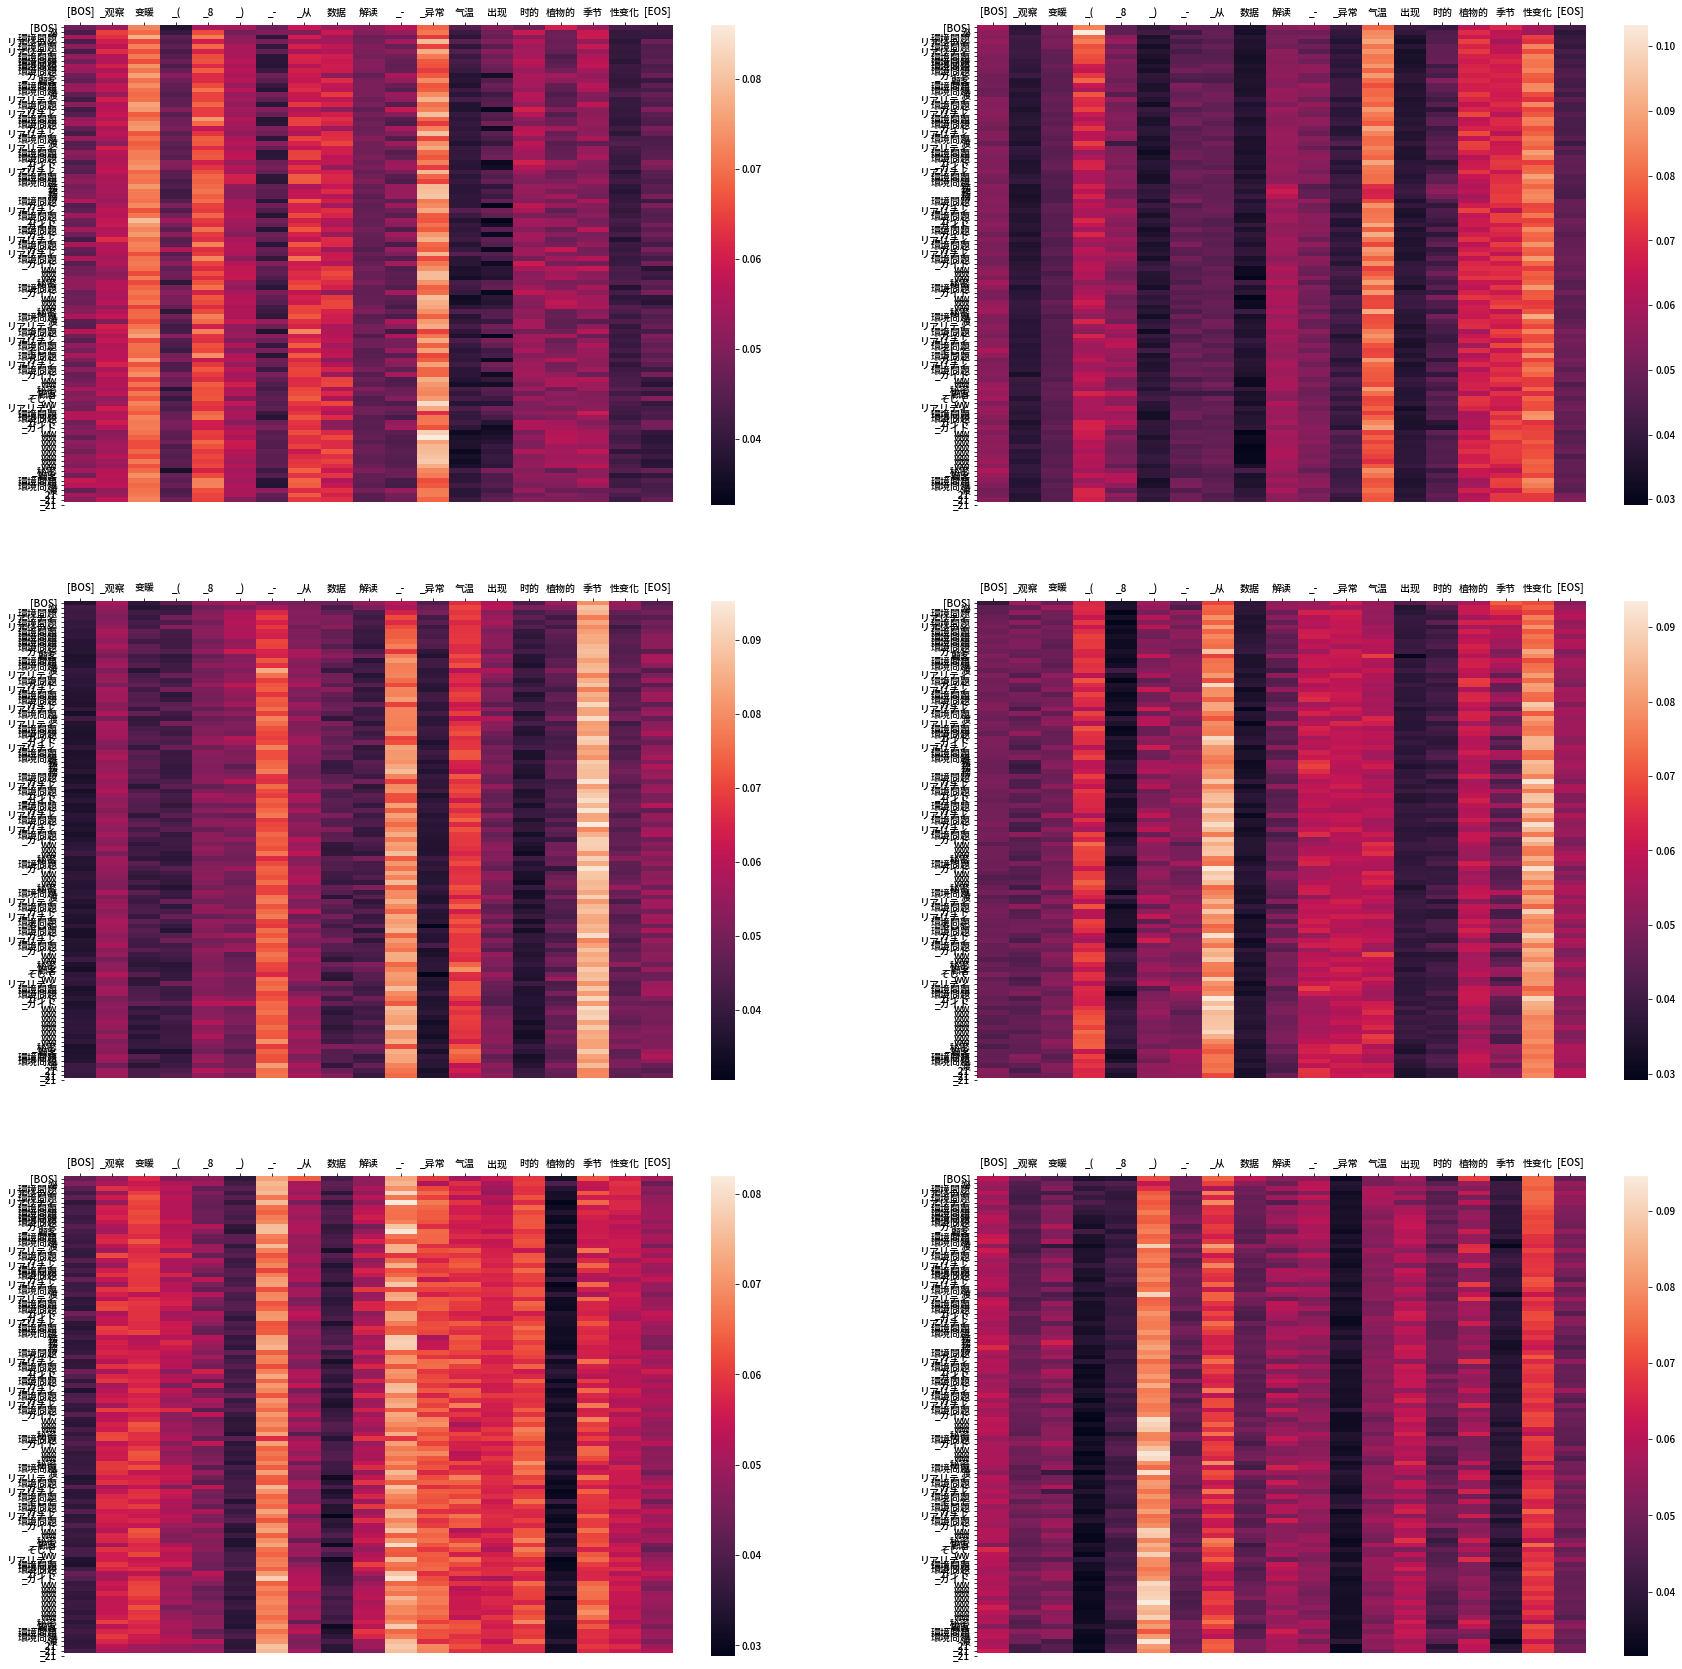

In [197]:
i=31
case_study(model.test_outputs[i][0],
           model.test_outputs[i][2],
           model.test_outputs[i][3],
           model.test_outputs[i][1].cpu().numpy())